# Replicating Laurenti et al.'s autoregressive forecast of p4581 with a TCN

### Intro & Context

Laurenti uses the segment of the experiment where normal stress = 8 MPa (see p53 of the supplementary material). Note that this is different to the segment provided in Adriano's data loader, which is at normal stress = 2 MPa. For more analysis on how the data varies with normal stress, see TRR26 002.

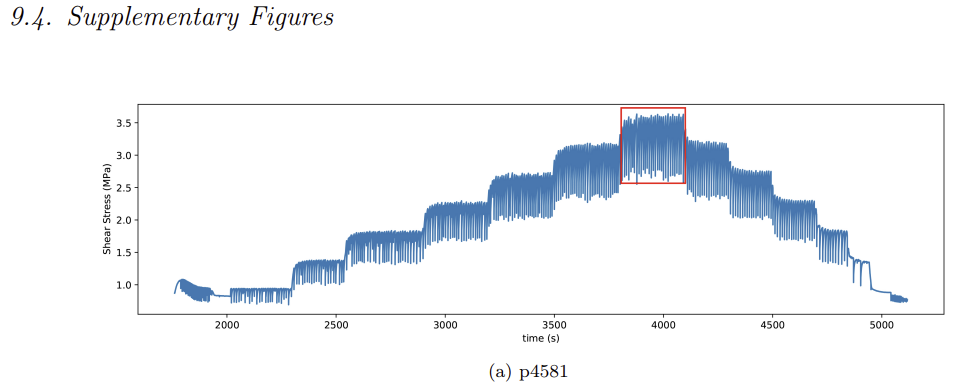

This segment is assumed (high confidence as charts match) to be between 3800 and 4100 seconds, based on the following extract p54 of the supplementary material.

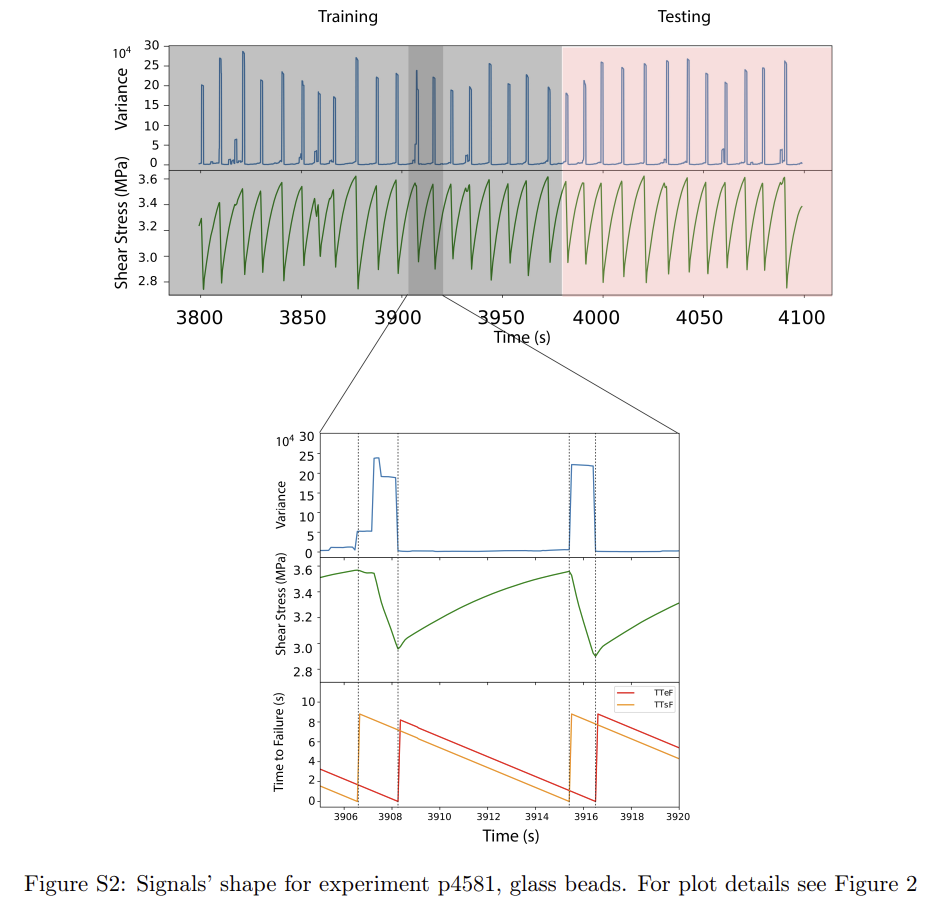

Note that this may not be a good choice as the experiment is transitioning out of 8 MPa normal stress at the beginning and end of this time segment (see extract from analysis in TRR 002). But we'll use it for now.

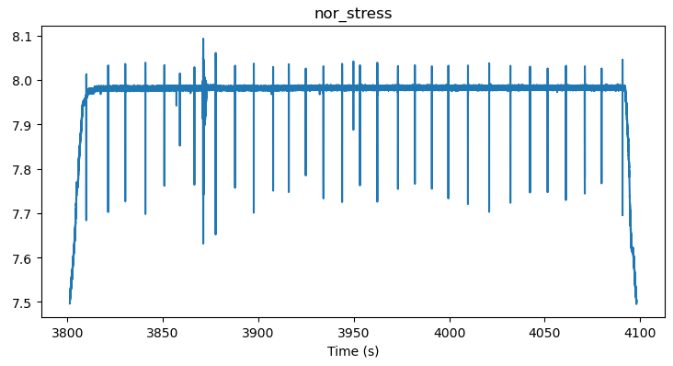

### Setting everything up

In [9]:
# Set Directories

MAIN_DIR = "/gws/nopw/j04/ai4er/users/trr26/earthquake-predictability"
DATA_DIR = "/gws/nopw/j04/ai4er/users/trr26/earthquake-predictability/data/gtc_quakes_data"
p4581_FILE_PATH = f"{DATA_DIR}/labquakes/Marone/p4581/p4581.txt"

# Imports

import os
import random
import sys
from math import sqrt

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import torch
import torch.nn as nn
from IPython.display import display
from scipy.io import loadmat
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm

sys.path.append(MAIN_DIR)
import utils

In [10]:
# Check CUDA Availability

if torch.cuda.is_available():
    dev = "cuda"
    map_location = None
    print(f"Total number of GPUs available: {torch.cuda.device_count()}")
    !nvidia-smi
else:
    dev = "cpu"
    map_location = "cpu"
    print("No GPU available.")
device = torch.device(dev)

Total number of GPUs available: 4
Thu Jan 18 14:00:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  | 00000000:01:00.0 Off |                    0 |
| N/A   31C    P0              57W / 400W |    560MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+---------------------------------

,time,lp_disp,shr_stress,nor_disp,nor_stress,sync,samp_freq
0,1.0,0.0,0.0,-0.0,1.000000e-18,3.29854,1
1,2.0,0.0,0.0,-0.0,1.000000e-18,3.29853,1
2,3.0,0.0,0.0,-0.0,1.000000e-18,3.29853,1
3,4.0,0.0,0.0,-0.0,1.000000e-18,3.29854,1
4,5.0,0.0,0.0,-0.0,1.000000e-18,3.29855,1


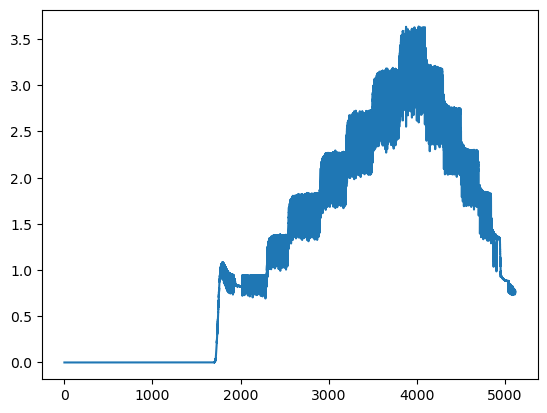

In [15]:
with open(p4581_FILE_PATH, "r") as file:
    df = pd.read_csv(file, delim_whitespace=True, skiprows=4)

df.columns = [
    "id",
    "lp_disp",
    "shr_stress",
    "nor_disp",
    "nor_stress",
    "time",
    "sync",
    "samp_freq",
]

df = df.drop(["id"], axis=1)
df = df[["time"] + [col for col in df.columns if col != "time"]]

plt.plot(df["time"], df["shr_stress"])

df.head()

In [16]:
## Define a de-trend function - we won't use this to start with


def detrend_first_order_poly(x, y):
    p = np.polyfit(x, y, deg=1)
    y_det = y - (p[0] * x + p[1])
    return y_det

### Define the time segment and visualise the data

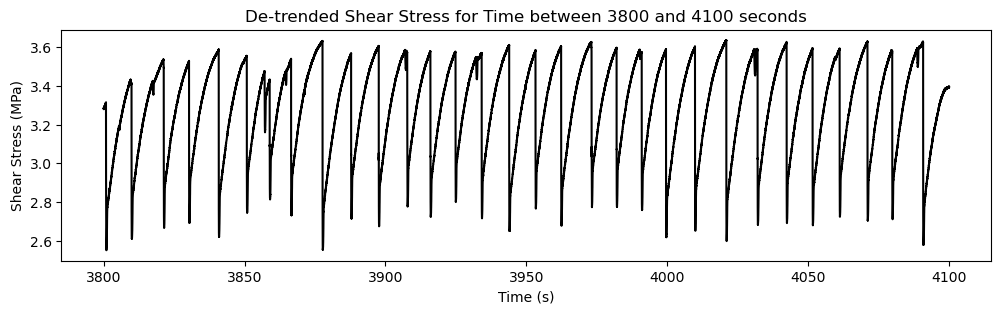

In [19]:
start_time = 3800
end_time = 4100

time_range = (df["time"] >= start_time) & (df["time"] <= end_time)

time = df.loc[time_range, "time"]
shear_stress = df.loc[time_range, "shr_stress"]
# y_det = detrend_first_order_poly(x, y)

plt.figure(figsize=(12, 3))
plt.plot(time, shear_stress, "-k")
plt.xlabel("Time (s)")
plt.ylabel("Shear Stress (MPa)")
plt.title(
    f"De-trended Shear Stress for Time between {start_time} and {end_time} seconds"
)
plt.show()

Note the near exact match with the chart above from supplementary material. The minimum value of some of the toughs appear lower in our graph, although this could be due to rendering differences. ***To do: check minimum points match.***

### Data pre-processing

The first thing Laurenti et al. does is min-max scaling (sklearn pre-processing) and then data smoothing using her own function.

***Comment: predicting smoothed data is presumably an easier task - do we want to do the same?***